In [11]:
from datasets import load_from_disk
ind=1
item='Ames Mutagenicity'

data_dict=load_from_disk(f'dataset\cv{ind}_aug')

data_dict=data_dict.select_columns(['smiles',item])
data_dict['test']=load_from_disk('test_ad')

train=data_dict['train'].to_pandas()
data_dict

DatasetDict({
    train: Dataset({
        features: ['smiles', 'Ames Mutagenicity'],
        num_rows: 10399
    })
    val: Dataset({
        features: ['smiles', 'Ames Mutagenicity'],
        num_rows: 586
    })
    test: Dataset({
        features: ['smiles', 'ids', 'Ames Mutagenicity'],
        num_rows: 573
    })
})

In [12]:
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, Trainer, TrainingArguments,GPT2DoubleHeadsModel,GPT2PreTrainedModel,GPT2ForSequenceClassification
from datasets import load_dataset

# 定义标记器和模型配置
tokenizer = GPT2Tokenizer.from_pretrained(r"D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt100.json")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id

100

In [13]:
from torch import nn
from transformers import AutoModelForSequenceClassification,GPT2ForSequenceClassification,GPT2Config
from torch.nn.utils import prune
class GPT2cls(nn.Module):
    def __init__(self,drop,purn,n_block):
        super(GPT2cls, self).__init__()
        self.config = GPT2Config.from_pretrained('D:\system\桌面\lcm-code\pre_training\chem_gpt100')  #  使用预训练的GPT2模型
        self.config.pad_token_id=tokenizer.pad_token_id
        self.config.num_labels=2
        self.config.num_attention_heads=4
        self.config.num_hidden_layers=n_block
        self.config.hidden_size=512
        self.model = AutoModelForSequenceClassification.from_config(self.config)
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
                module.p = drop
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=purn)
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids,attention_mask=attention_mask)
        return outputs

model=GPT2cls(0.144,0.2,3)
model.load_state_dict(torch.load('best_val.model'))

<All keys matched successfully>

In [14]:
tokenized_dataset = data_dict.map(
    lambda element: tokenizer(element['smiles']), batched=True
)

tokenized_dataset = tokenized_dataset.select_columns(['input_ids', 'attention_mask', item])
tokenized_dataset

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 10399
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 586
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 573
    })
})

In [15]:
tokenized_dataset
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_dataset.set_format("torch")

eval_dataloader = DataLoader(tokenized_dataset["val"], batch_size=20, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=20, collate_fn=data_collator)
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=84, collate_fn=data_collator, shuffle=True)

In [16]:
from accelerate import Accelerator
Accelerator.mixed_precision == 'fp16'
accelerator = Accelerator()

#
eval_dataloader,test_dataloader,train_dataloader,model = accelerator.prepare(
     eval_dataloader,test_dataloader,train_dataloader,model)

In [17]:
import numpy as np
def acc(loader,model):
    predicts=[]
    labels=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            label = batch[item].to(torch.int64)
            # batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask']).logits

            predict=torch.argmax(logits,dim=1)
            predicts.append(predict.flatten().cpu().numpy())
            labels.append(label.flatten().cpu().numpy())

    predicts=np.concatenate(predicts)
    labels=np.concatenate(labels)
    torch.cuda.empty_cache()
    return labels,predicts

Accuracy: 0.8411867364746946
Precision: 0.8483870967741935
Recall: 0.8566775244299675
F1 Score: 0.8525121555915721
Specificity: 0.8233082706766918


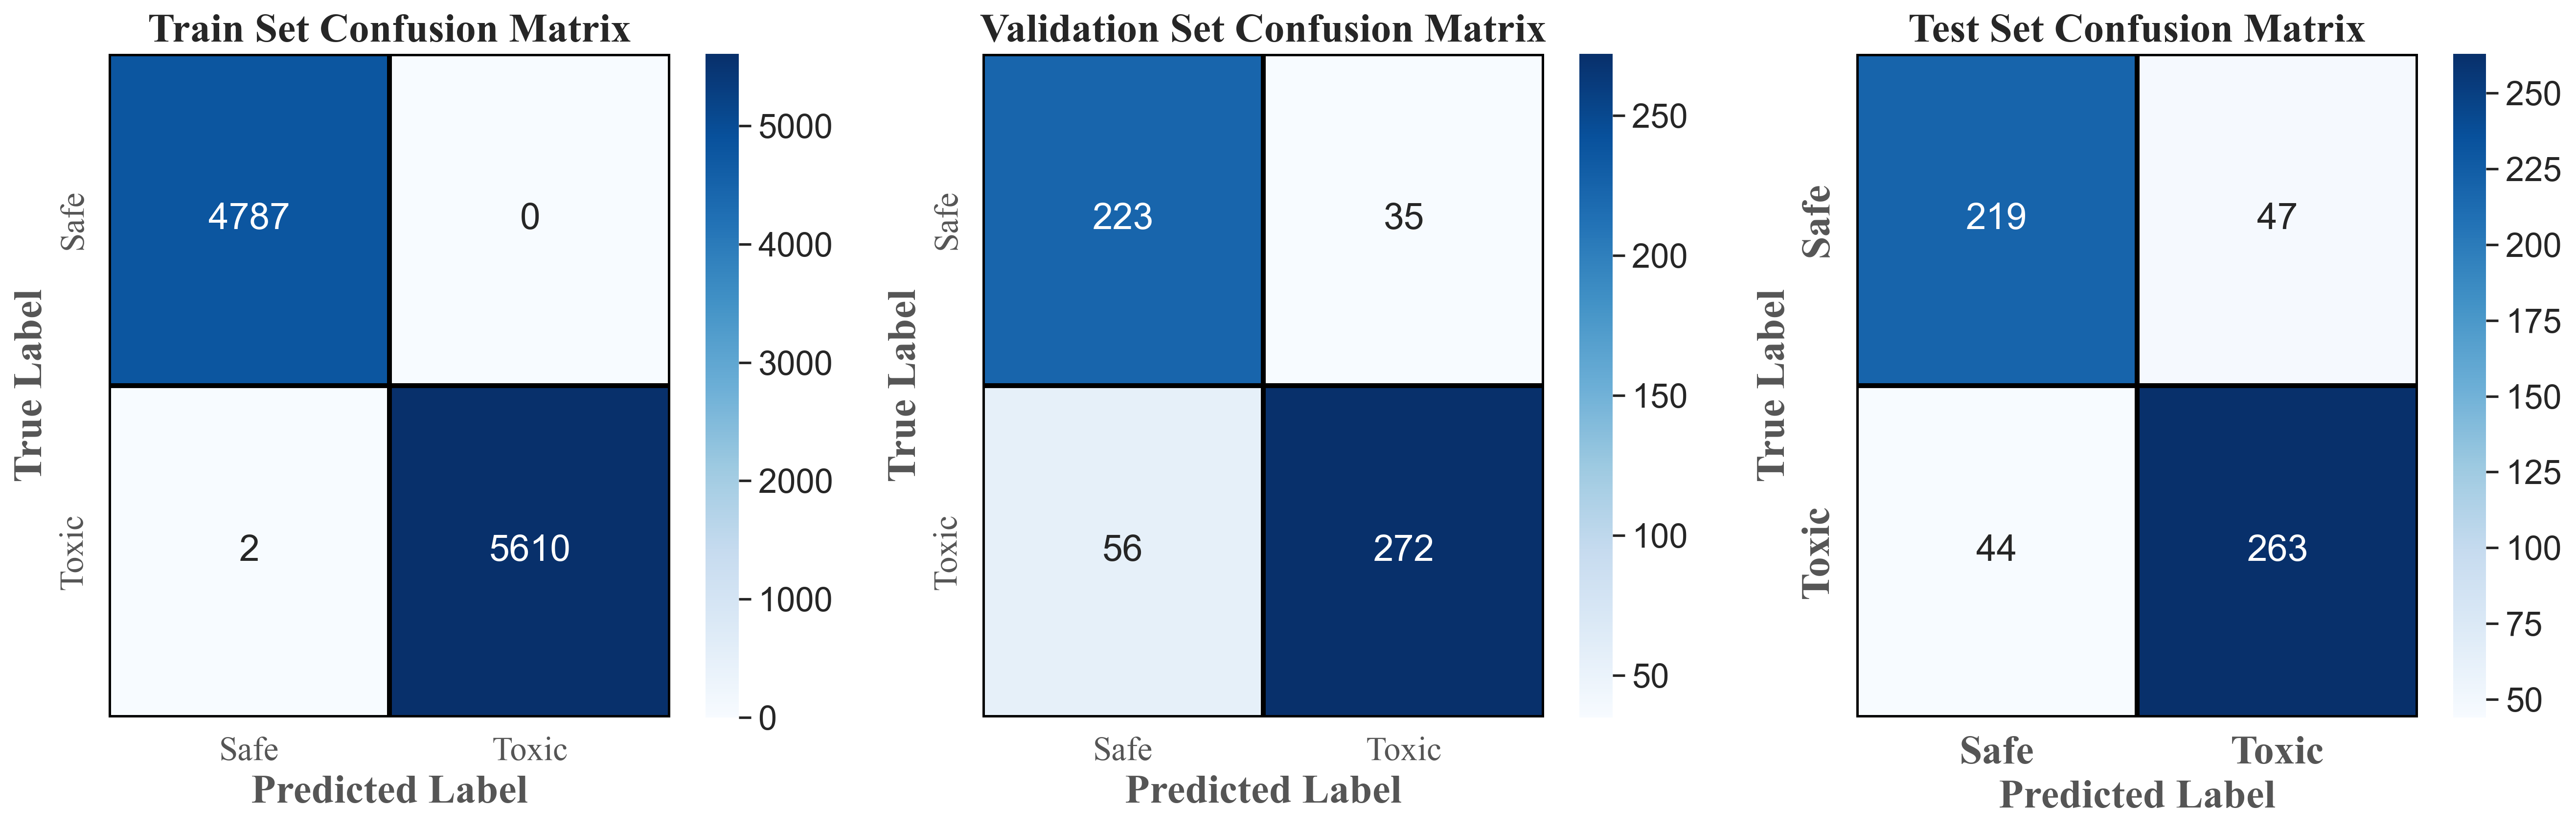

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 生成示例数据
y_train_true, y_train_pred = acc(train_dataloader, model)
y_val_true, y_val_pred = acc(eval_dataloader, model)
y_test_true, y_test_pred = acc(test_dataloader, model)

accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true,y_test_pred)
recall= recall_score(y_test_true, y_test_pred)
f1= f1_score(y_test_true, y_test_pred)



print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

tn, fp, fn, tp = confusion_matrix(y_test_true, y_test_pred).ravel()

specificity = tn / (tn + fp)
print("Specificity:", specificity)
# 计算混淆矩阵
conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
# 绘制热图
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

# 设置字体大小
sns.set(font_scale=1.5)

# 训练集混淆矩阵
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='d', ax=axs[0], xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'], linewidths=2, linecolor='black')
axs[0].set_title('Train Set Confusion Matrix',fontweight='bold',fontsize=20)
axs[0].set_xlabel('Predicted Label',fontweight='bold',fontsize=20)
axs[0].set_ylabel('True Label',fontweight='bold',fontsize=20)

plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
# 验证集混淆矩阵
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='d', ax=axs[1], xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'], linewidths=2, linecolor='black')
axs[1].set_title('Validation Set Confusion Matrix',fontweight='bold',fontsize=20)
axs[1].set_xlabel('Predicted Label',fontweight='bold',fontsize=20)
axs[1].set_ylabel('True Label',fontweight='bold',fontsize=20)

plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
# 测试集混淆矩阵
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='d', ax=axs[2], xticklabels=['Safe', 'Toxic'], yticklabels=['Safe', 'Toxic'], linewidths=2, linecolor='black')
axs[2].set_title('Test Set Confusion Matrix',fontweight='bold',fontsize=20)
axs[2].set_xlabel('Predicted Label',fontweight='bold',fontsize=20)
axs[2].set_ylabel('True Label',fontweight='bold',fontsize=20)

plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()


In [24]:

import torch
import numpy as np
from sklearn.metrics import roc_auc_score

def auc_score(loader, model):
    predicts = []
    labels = []
    model.eval()

    for batch in loader:
        with torch.no_grad():
            label = batch[item].to(torch.int64)
            logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).logits

            # 获取预测概率
            probabilities = torch.softmax(logits, dim=-1)
            # 获取属于第一个类别的概率，这里假设第一个类别是正类别
            positive_probs = probabilities[:, 1]

            predicts.append(positive_probs.cpu().numpy())
            labels.append(label.cpu().numpy())

    # 重组数据以计算ROC曲线和AUC
    predicts = np.concatenate(predicts)
    labels = np.concatenate(labels)
    torch.cuda.empty_cache()

    return labels, predicts

# 使用函数



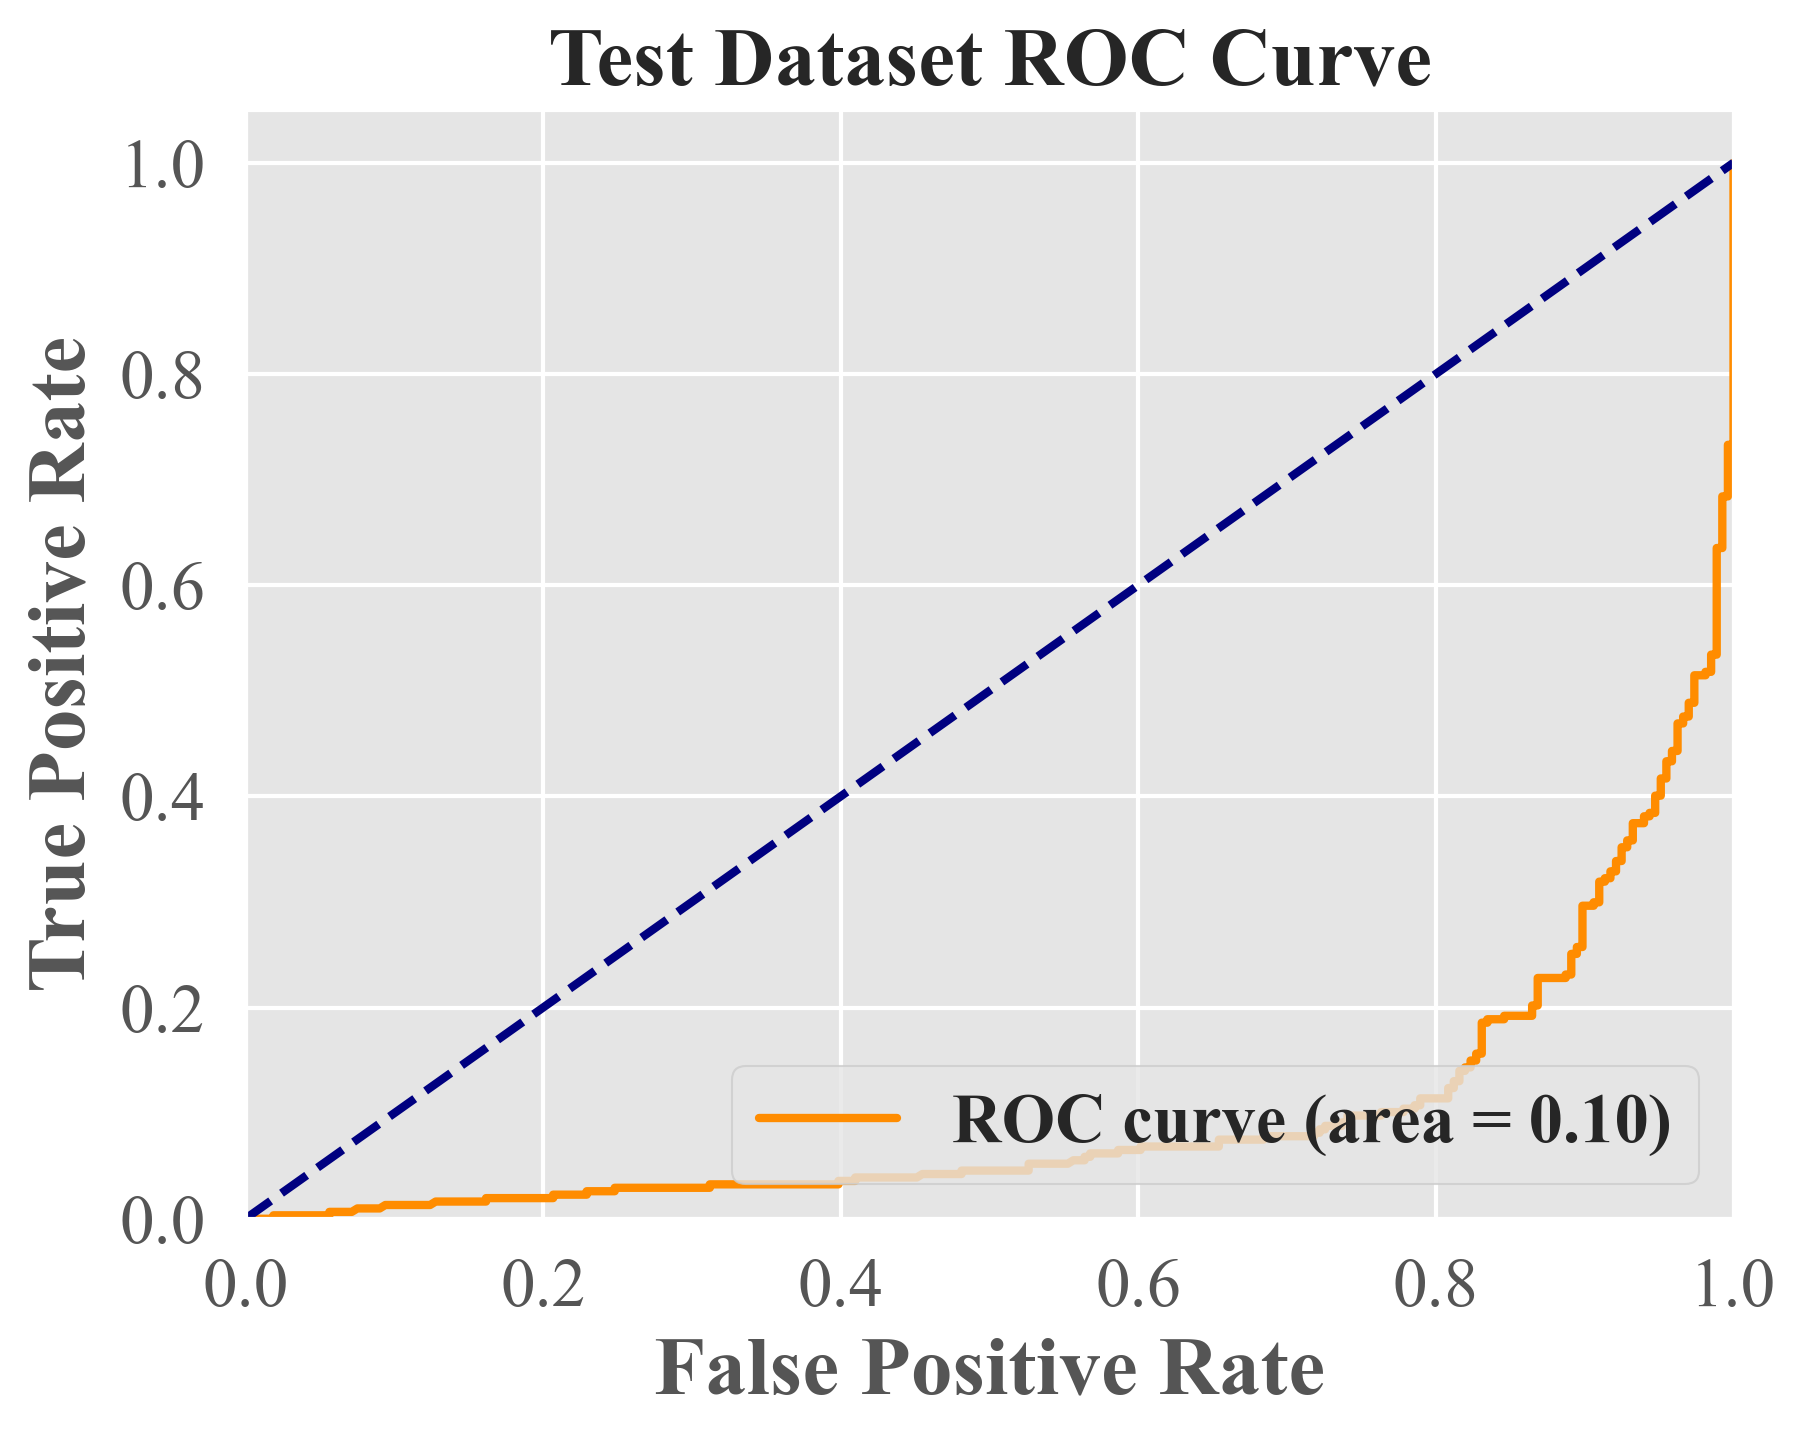

0.09659939751659277


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

# 假设你已经有了实际标签和预测的概率
# 这里我简单地生成了一些示例数据
y_true, y_score=auc_score(test_dataloader,model)

# 计算ROC曲线的假正例率（FPR）和真正例率（TPR）
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold',fontsize=20)
plt.ylabel('True Positive Rate', fontweight='bold',fontsize=20)
plt.title('Test Dataset ROC Curve', fontweight='bold',fontsize=20)
plt.legend(loc="lower right", prop={'weight':'bold'})
plt.show()

print(roc_auc_score(y_true, y_score))


In [12]:
torch.max(torch.tensor([[1,5,6],[2,5,8]]),dim=-1)

torch.return_types.max(
values=tensor([6, 8]),
indices=tensor([2, 2]))